# CS294 - 082 Project: Efficient Compression and Memory Equivalent Capacity Estimate of AlexNet 

## Author

- Jingjing Wei, Fang Hu, Yonghao Zhu
- University of California Berkeley, Berkeley, CA, USA
- {jingjingwei, fanghu, yonghao_zhu}@berkeley.edu


## Introduction

- In this project, we customize the AlexNet and analyze its experimental properties. The dataset used in the paper is Fashion MNIST. We chose three classes to train and test our model, including 0 (T-shirt), 1 (Trouser), and 2 (Pullover). Also, we performed random data sampling. 
- Two experiments were studied in this paper. (1) Accuracy vs. Memory Equivalent Capacity. (2) The proportion of Training Data vs. MEC(Overfitting). 
- Based on the result, we discuss multiple properties of our machine learner, including memory equivalent capacity, generalization, resilience, etc., by adjusting the number of neurons of fully connected layers. The capacity of the dataset and model are further explored. Moreover, we discuss our experiment's quality assurance, repeatability, and reproducibility. 

In [9]:
import os
import torch
import torchvision
import torchvision.datasets as datasets
import numpy as np

# Maps integer class index to human-readable string describing the class
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
raw_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True)

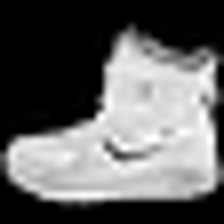

ankle boot


In [10]:
img_index = 0
tup = raw_dataset[img_index]
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

## Define Model

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import *
from typing import Any
from torch.hub import load_state_dict_from_url


model_urls = {
    "alexnet": "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth",
}


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5, fc_parameter: int = 4096) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((13, 13))
        
        # MEC = (192 * 13 * 13 + 1) * fc_parameter + fc_parameter + fc_parameter = 32451 * fc_parameter
        self.classifier = nn.Sequential(
#             nn.Dropout(p=dropout),
            nn.Linear(192 * 13 * 13, fc_parameter),
            nn.ReLU(inplace=True),
            nn.Linear(fc_parameter, fc_parameter),
            nn.ReLU(inplace=True),
#             nn.Dropout(p=dropout),
            nn.Linear(fc_parameter, fc_parameter), 
            nn.ReLU(inplace=True),
            nn.Linear(fc_parameter, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    The required minimum input size of the model is 63x63.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls["alexnet"], progress=progress)
        model.load_state_dict(state_dict)
    return model

def _log_api_usage_once(obj: str) -> None:  # type: ignore
    if torch.jit.is_scripting() or torch.jit.is_tracing():
        return
    # NOTE: obj can be an object as well, but mocking it here to be
    # only a string to appease torchscript
    if isinstance(obj, str):
        torch._C._log_api_usage_once(obj)
    else:
        torch._C._log_api_usage_once(f"{obj.__module__}.{obj.__class__.__name__}")

In [83]:
def train_model(net,train_loader,num_epochs):
    # Note: this will take 5-10 minutes to run.
    #num_epochs = 10
    loss_fn = torch.nn.CrossEntropyLoss()#define loss function
    optimizer = torch.optim.Adam(net.parameters(),lr=1e-5)#define optimizer
    
    # Ensures network is in train mode
    net.train()

    start_time = time.time()
    for epoch in range(num_epochs):
        for data, targets in iter(train_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = net(data)

            # Computes loss
            loss = loss_fn(results, targets)

            # Updates model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("#" * 10 + " " + "epoch" + str(epoch + 1) + " " + "#" * 10)
        print("For train dataset:")
        eval_network(net, train_loader)
        print("For test dataset:")
        eval_network(net, test_loader)
    
    elapsed_time = time.time() - start_time
    print ("Spent ", elapsed_time, " seconds training for ", num_epochs, " epoch(s) on a single core.")

In [84]:
import time

# Runs the given net on the batches provided by the test_loader
# Records the number of correct predictions (guesses) and 
# prints the percentage of correct guesses on the dataset, plus a 
# sample batch.
def eval_network(model, test_loader):
    start_time = time.time()
    num_correct = 0
    total_guesses = 0

    # Sets eval and no grad context for evaluation
    model.eval()
    with torch.no_grad():
        for data, targets in iter(test_loader):
            # Sends data and targets to device
            data = data.to(device)
            targets = targets.to(device)

            # Acquires the network's best guesses at each class
            results = model(data)
            best_guesses = torch.argmax(results, 1)

            # Updates number of correct and total guesses
            num_correct += torch.eq(targets, best_guesses).sum().item()
            total_guesses += batch_size

    # Prints output
    elapsed_time = time.time() - start_time
    print("Correctly guessed ", num_correct/total_guesses*100, "%")
#     print("Evaluated in ", elapsed_time, " seconds")
    return num_correct/total_guesses*100

## Load and Define Dataset

In [72]:
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Resize((224, 224))
my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
train_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True,
  transform=my_transform)

test_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=False,
  download=True,
  transform=my_transform)

In [75]:
def reduce(raw_dataset):
    # reduce the dataset to only contains class 0 and 1
    # total count: 12000
    
    class_list = [1, 2]
    idx = (raw_dataset.targets==0)
    for c in class_list:
        idx = idx | (raw_dataset.targets==c)

    # reduce data to make the model training more efficient
    np.random.seed(88)
    idx = idx & torch.from_numpy(np.random.choice([True, False], size=len(idx), p=[0.05, 0.95]))
#     for i in range(len(idx)):
#         if i % 2 == 0 or i % 3 == 0 or i % 5 == 0 or i % 7 == 0 or i % 8 == 0:
#             idx[i] = False
    raw_dataset.targets = raw_dataset.targets[idx]
    raw_dataset.data = raw_dataset.data[idx]

In [76]:
reduce(train_dataset)
reduce(test_dataset)

In [77]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 924
    Root location: /tmp/fashionmnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Lambda()
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [78]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 155
    Root location: /tmp/fashionmnist
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Lambda()
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [79]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.RandomSampler(test_dataset)

In [80]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=test_sampler)

In [81]:
def label_stat(data_loader):
    res = []
    number_zero = 0
    number_one = 0
    number_two = 0
    for data, targets in iter(data_loader):
        number_zero = number_zero + list(targets).count(0)
        number_one = number_one + list(targets).count(1)
        number_two = number_two + list(targets).count(2)
    print("number of 0 class: " + str(number_zero))
    print("number of 1 class: " + str(number_one))
    print("number of 2 class: " + str(number_two))
    return [number_zero, number_one, number_two]
    
print("###### Train data ######")
train_data_stat = label_stat(train_loader)

print("###### Test data ######")
test_data_stat = label_stat(test_loader)

###### Train data ######
number of 0 class: 306
number of 1 class: 319
number of 2 class: 299
###### Test data ######
number of 0 class: 57
number of 1 class: 49
number of 2 class: 49


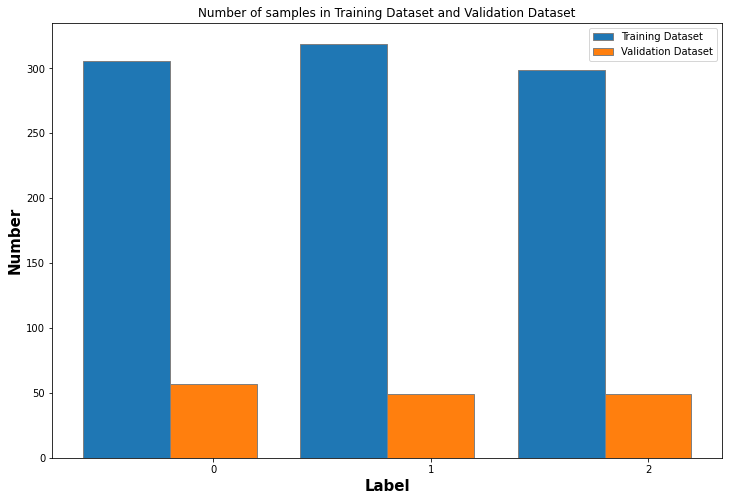

In [85]:
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.4
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Training = train_data_stat
Validation = test_data_stat
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, IT, width = barWidth,
        edgecolor ='grey', label ='Training Dataset')
plt.bar(br2, ECE, width = barWidth,
        edgecolor ='grey', label ='Validation Dataset')
 
# Adding Xticks
plt.xlabel('Label', fontweight ='bold', fontsize = 15)
plt.ylabel('Number', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        ['0', '1', '2'])
plt.title("Number of samples in Training Dataset and Validation Dataset")
plt.legend()
plt.show()

## 1. Accuracy vs. Memory Equivalent Capacity

### 3-Class Classification

In [40]:
net = alexnet(num_classes=3, fc_parameter=9216)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)
print("########## Validation Accuracy: ##########")
eval_network(net, test_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  90.53191489361701 %
For test dataset:
Correctly guessed  90.625 %
########## epoch2 ##########
For train dataset:
Correctly guessed  94.57446808510637 %
For test dataset:
Correctly guessed  92.5 %
########## epoch3 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  93.125 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  96.17021276595744 %
For test dataset:
Correctly guessed  90.625 %
########## epoch6 ##########
For train dataset:
Correctly guessed  96.70212765957447 %
For test dataset:
Correctly guessed  93.75 %
########## epoch7 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  90.0 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.9148

94.375

In [57]:
train_acc_list = [95.53, 96.06, 96.70, 97.65, 97.97, 97.98, 97.97]
test_acc_list = [91.8, 93.12, 93.7, 93.7, 94.37, 94.38, 93.75]
mec_list = []
fc_parameter_list = [512, 1024, 3072, 6144, 8192, 9216, 11264]

for fc_parameter in fc_parameter_list:
#     net = alexnet(num_classes=3, fc_parameter=fc_parameter)
#     net = net.to(device)#to GPU

#     train_model(net, train_loader, 10)
    
    mec = 32451 * fc_parameter
    mec_list.append(mec)
#     train_acc_list.append(eval_network(net, train_loader))
#     test_acc_list.append(eval_network(net, test_loader))

In [58]:
fc_parameter_list = [512, 1024, 3072, 6144, 8192, 9216, 11264]

In [59]:
neroun_list = []## number of nerouns

In [60]:
for fc_parameter in fc_parameter_list:
    neroun = 3 * fc_parameter + 3
    neroun_list.append(neroun)

In [61]:
neroun_list

[1539, 3075, 9219, 18435, 24579, 27651, 33795]

In [62]:
mec_list

[16614912, 33229824, 99689472, 199378944, 265838592, 299068416, 365528064]

In [63]:
train_acc_list

[95.53, 96.06, 96.7, 97.65, 97.97, 97.98, 97.97]

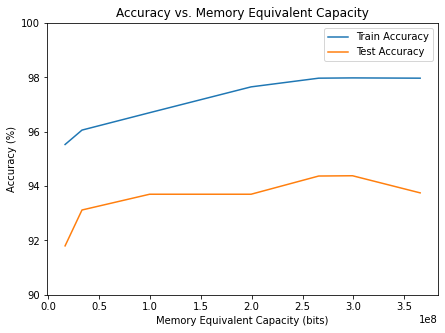

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(mec_list, train_acc_list, label = "Train Accuracy")
plt.plot(mec_list, test_acc_list, label = "Test Accuracy")
plt.xlabel("Memory Equivalent Capacity (bits)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Memory Equivalent Capacity")
plt.ylim(90, 100) 
plt.legend();

## 2. %Training Data vs. MEC(Overfitting)

### 10% Training Data

In [62]:
indices = torch.randperm(len(train_dataset))[:92]#10% training data

In [63]:
train_dataset_10 = torch.utils.data.Subset(train_dataset, indices)
train_sampler_10 = torch.utils.data.RandomSampler(train_dataset_10)

In [64]:
batch_size = 20

train_loader_10 = torch.utils.data.DataLoader(
    train_dataset_10,
    batch_size=batch_size,
    sampler=train_sampler_10)

In [52]:
net = alexnet(num_classes=3, fc_parameter=3072)
net = net.to(device)#to GPU

train_model(net, train_loader, 15)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  90.95744680851064 %
For test dataset:
Correctly guessed  93.125 %
########## epoch2 ##########
For train dataset:
Correctly guessed  94.68085106382979 %
For test dataset:
Correctly guessed  93.75 %
########## epoch3 ##########
For train dataset:
Correctly guessed  92.23404255319149 %
For test dataset:
Correctly guessed  90.625 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.53191489361701 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  95.63829787234043 %
For test dataset:
Correctly guessed  93.75 %
########## epoch6 ##########
For train dataset:
Correctly guessed  94.04255319148936 %
For test dataset:
Correctly guessed  90.625 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.17021276595744 %
For test dataset:
Correctly guessed  93.75 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.80

97.44680851063829

In [47]:
net = alexnet(num_classes=3, fc_parameter=2048)
net = net.to(device)#to GPU

train_model(net, train_loader, 15)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  92.65957446808511 %
For test dataset:
Correctly guessed  91.25 %
########## epoch2 ##########
For train dataset:
Correctly guessed  92.5531914893617 %
For test dataset:
Correctly guessed  91.25 %
########## epoch3 ##########
For train dataset:
Correctly guessed  93.61702127659575 %
For test dataset:
Correctly guessed  92.5 %
########## epoch4 ##########
For train dataset:
Correctly guessed  94.46808510638299 %
For test dataset:
Correctly guessed  91.875 %
########## epoch5 ##########
For train dataset:
Correctly guessed  94.46808510638299 %
For test dataset:
Correctly guessed  91.875 %
########## epoch6 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  93.125 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.27659574468085 %
For test dataset:
Correctly guessed  93.125 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.3829

96.91489361702128

In [65]:
net = alexnet(num_classes=3, fc_parameter=2560)
net = net.to(device)#to GPU

train_model(net, train_loader, 15)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  90.95744680851064 %
For test dataset:
Correctly guessed  89.375 %
########## epoch2 ##########
For train dataset:
Correctly guessed  93.40425531914893 %
For test dataset:
Correctly guessed  91.25 %
########## epoch3 ##########
For train dataset:
Correctly guessed  95.1063829787234 %
For test dataset:
Correctly guessed  93.125 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.0 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  95.31914893617022 %
For test dataset:
Correctly guessed  90.0 %
########## epoch6 ##########
For train dataset:
Correctly guessed  95.0 %
For test dataset:
Correctly guessed  92.5 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.27659574468085 %
For test dataset:
Correctly guessed  93.125 %
########## epoch8 ##########
For train dataset:
Correctly guessed  95.42553191489361 %
For test datas

97.87234042553192

### 20% Training Data

In [39]:
indices = torch.randperm(len(train_dataset))[:185]#10% training data
train_dataset_20 = torch.utils.data.Subset(train_dataset, indices)
train_sampler_20 = torch.utils.data.RandomSampler(train_dataset_20)

In [40]:
batch_size = 20

train_loader_20 = torch.utils.data.DataLoader(
    train_dataset_20,
    batch_size=batch_size,
    sampler=train_sampler_20)

In [41]:
net = alexnet(num_classes=3, fc_parameter=4096)
net = net.to(device)#to GPU

train_model(net, train_loader, 15)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  88.51063829787233 %
For test dataset:
Correctly guessed  86.25 %
########## epoch2 ##########
For train dataset:
Correctly guessed  93.93617021276596 %
For test dataset:
Correctly guessed  90.625 %
########## epoch3 ##########
For train dataset:
Correctly guessed  92.76595744680851 %
For test dataset:
Correctly guessed  92.5 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.1063829787234 %
For test dataset:
Correctly guessed  90.625 %
########## epoch5 ##########
For train dataset:
Correctly guessed  95.95744680851064 %
For test dataset:
Correctly guessed  92.5 %
########## epoch6 ##########
For train dataset:
Correctly guessed  96.38297872340425 %
For test dataset:
Correctly guessed  93.125 %
########## epoch7 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  92.5 %
########## epoch8 ##########
For train dataset:
Correctly guessed  97.0212765

97.5531914893617

In [48]:
net = alexnet(num_classes=3, fc_parameter=3072)
net = net.to(device)#to GPU

train_model(net, train_loader, 15)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  92.76595744680851 %
For test dataset:
Correctly guessed  92.5 %
########## epoch2 ##########
For train dataset:
Correctly guessed  90.0 %
For test dataset:
Correctly guessed  87.5 %
########## epoch3 ##########
For train dataset:
Correctly guessed  94.68085106382979 %
For test dataset:
Correctly guessed  91.25 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  92.5 %
########## epoch5 ##########
For train dataset:
Correctly guessed  95.85106382978724 %
For test dataset:
Correctly guessed  93.75 %
########## epoch6 ##########
For train dataset:
Correctly guessed  95.85106382978724 %
For test dataset:
Correctly guessed  91.875 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.80851063829788 %
For test dataset:
Correctly guessed  93.125 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.48936170212767 %
For

97.65957446808511

### 40% Training Data

In [79]:
indices = torch.randperm(len(train_dataset))[:370]#10% training data
train_dataset_40 = torch.utils.data.Subset(train_dataset, indices)
train_sampler_40 = torch.utils.data.RandomSampler(train_dataset_40)

In [80]:
batch_size = 20

train_loader_40 = torch.utils.data.DataLoader(
    train_dataset_40,
    batch_size=batch_size,
    sampler=train_sampler_40)

In [55]:
net = alexnet(num_classes=3, fc_parameter=4096)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  89.25531914893618 %
For test dataset:
Correctly guessed  88.75 %
########## epoch2 ##########
For train dataset:
Correctly guessed  93.93617021276596 %
For test dataset:
Correctly guessed  92.5 %
########## epoch3 ##########
For train dataset:
Correctly guessed  94.57446808510637 %
For test dataset:
Correctly guessed  90.0 %
########## epoch4 ##########
For train dataset:
Correctly guessed  94.36170212765957 %
For test dataset:
Correctly guessed  92.5 %
########## epoch5 ##########
For train dataset:
Correctly guessed  96.27659574468085 %
For test dataset:
Correctly guessed  93.125 %
########## epoch6 ##########
For train dataset:
Correctly guessed  96.80851063829788 %
For test dataset:
Correctly guessed  93.125 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.48936170212767 %
For test dataset:
Correctly guessed  93.125 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.702127

97.87234042553192

In [56]:
net = alexnet(num_classes=3, fc_parameter=3072)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  89.46808510638297 %
For test dataset:
Correctly guessed  91.875 %
########## epoch2 ##########
For train dataset:
Correctly guessed  94.14893617021278 %
For test dataset:
Correctly guessed  93.75 %
########## epoch3 ##########
For train dataset:
Correctly guessed  93.72340425531915 %
For test dataset:
Correctly guessed  90.0 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.2127659574468 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  94.8936170212766 %
For test dataset:
Correctly guessed  91.25 %
########## epoch6 ##########
For train dataset:
Correctly guessed  96.48936170212767 %
For test dataset:
Correctly guessed  93.125 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.48936170212767 %
For test dataset:
Correctly guessed  93.75 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.914893

97.65957446808511

In [81]:
net = alexnet(num_classes=3, fc_parameter=3584)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  92.12765957446808 %
For test dataset:
Correctly guessed  91.25 %
########## epoch2 ##########
For train dataset:
Correctly guessed  93.72340425531915 %
For test dataset:
Correctly guessed  91.875 %
########## epoch3 ##########
For train dataset:
Correctly guessed  95.0 %
For test dataset:
Correctly guessed  92.5 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.63829787234043 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  95.2127659574468 %
For test dataset:
Correctly guessed  92.5 %
########## epoch6 ##########
For train dataset:
Correctly guessed  93.08510638297872 %
For test dataset:
Correctly guessed  90.625 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.48936170212767 %
For test dataset:
Correctly guessed  93.125 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.59574468085106 %
F

97.76595744680851

### 80% Training Data

In [66]:
indices = torch.randperm(len(train_dataset))[:740]#10% training data
train_dataset_80 = torch.utils.data.Subset(train_dataset, indices)
train_sampler_80 = torch.utils.data.RandomSampler(train_dataset_80)

In [67]:
batch_size = 20

train_loader_80 = torch.utils.data.DataLoader(
    train_dataset_80,
    batch_size=batch_size,
    sampler=train_sampler_80)

In [59]:
net = alexnet(num_classes=3, fc_parameter=4096)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  92.87234042553192 %
For test dataset:
Correctly guessed  93.125 %
########## epoch2 ##########
For train dataset:
Correctly guessed  94.68085106382979 %
For test dataset:
Correctly guessed  92.5 %
########## epoch3 ##########
For train dataset:
Correctly guessed  94.04255319148936 %
For test dataset:
Correctly guessed  92.5 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.95744680851064 %
For test dataset:
Correctly guessed  91.25 %
########## epoch5 ##########
For train dataset:
Correctly guessed  95.95744680851064 %
For test dataset:
Correctly guessed  93.125 %
########## epoch6 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  91.875 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.38297872340425 %
For test dataset:
Correctly guessed  93.75 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.70212

97.65957446808511

In [68]:
net = alexnet(num_classes=3, fc_parameter=3072)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  90.1063829787234 %
For test dataset:
Correctly guessed  92.5 %
########## epoch2 ##########
For train dataset:
Correctly guessed  94.04255319148936 %
For test dataset:
Correctly guessed  93.125 %
########## epoch3 ##########
For train dataset:
Correctly guessed  94.36170212765957 %
For test dataset:
Correctly guessed  93.125 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.74468085106383 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  93.82978723404256 %
For test dataset:
Correctly guessed  92.5 %
########## epoch6 ##########
For train dataset:
Correctly guessed  96.17021276595744 %
For test dataset:
Correctly guessed  93.75 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.70212765957447 %
For test dataset:
Correctly guessed  93.75 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.489361

97.23404255319149

### 100%Training Data

In [89]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler)

In [93]:
net = alexnet(num_classes=3, fc_parameter=4096)
net = net.to(device)#to GPU

train_model(net, train_loader, 13)#9216,9216,4096,2048, 2;15epoch
print("########## Training Accuracy: ##########")
eval_network(net, train_loader)

########## epoch1 ##########
For train dataset:
Correctly guessed  89.57446808510639 %
For test dataset:
Correctly guessed  92.5 %
########## epoch2 ##########
For train dataset:
Correctly guessed  94.68085106382979 %
For test dataset:
Correctly guessed  90.625 %
########## epoch3 ##########
For train dataset:
Correctly guessed  93.72340425531915 %
For test dataset:
Correctly guessed  92.5 %
########## epoch4 ##########
For train dataset:
Correctly guessed  95.1063829787234 %
For test dataset:
Correctly guessed  93.125 %
########## epoch5 ##########
For train dataset:
Correctly guessed  96.17021276595744 %
For test dataset:
Correctly guessed  93.125 %
########## epoch6 ##########
For train dataset:
Correctly guessed  95.53191489361701 %
For test dataset:
Correctly guessed  92.5 %
########## epoch7 ##########
For train dataset:
Correctly guessed  96.48936170212767 %
For test dataset:
Correctly guessed  93.125 %
########## epoch8 ##########
For train dataset:
Correctly guessed  96.808510

97.23404255319149

### Plot

In [66]:
pro_dataset = [0, 10, 20, 40, 80, 100]

In [67]:
mec_list = []
fc_parameter_list = [0, 2560, 3072, 3584, 4096, 4096]

for fc_parameter in fc_parameter_list:
#     net = alexnet(num_classes=3, fc_parameter=fc_parameter)
#     net = net.to(device)#to GPU

#     train_model(net, train_loader, 10)
    
    mec = 32451 * fc_parameter
    mec_list.append(mec)

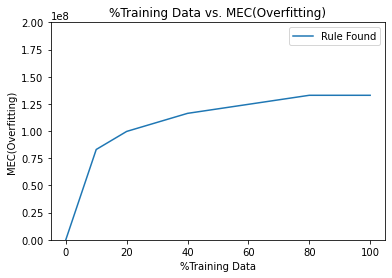

In [68]:
import matplotlib.pyplot as plt
plt.ylim(0, 2e8)

plt.plot(pro_dataset, mec_list, label = "Rule Found")

plt.xlabel("%Training Data")
plt.ylabel("MEC(Overfitting)")
plt.title("%Training Data vs. MEC(Overfitting)");##At leaset 97.76%
plt.legend();